In [ ]:
!pip install -q kagglehub tensorflow scikit-learn seaborn

import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

import kagglehub

print("TensorFlow version:", tf.__version__)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

TensorFlow version: 2.19.0


In [ ]:
# Download datasets (only first time; afterwards Colab cache is used)
neu_path = kagglehub.dataset_download("fantacher/neu-metal-surface-defects-data")
gc10_path = kagglehub.dataset_download("zhangyunsheng/defects-class-and-location")

print("NEU path:", neu_path)
print("GC10 path:", gc10_path)
print("\nNEU contents:", os.listdir(neu_path))
print("GC10 contents:", os.listdir(gc10_path))

# --- NEU dirs (train/valid/test each with 6 subfolders) ---
neu_root = Path(neu_path) / "NEU Metal Surface Defects Data"
neu_train_dir = neu_root / "train"
neu_valid_dir = neu_root / "valid"
neu_test_dir  = neu_root / "test"

print("\nNEU train dir:", neu_train_dir, neu_train_dir.exists())
print("NEU valid dir:", neu_valid_dir, neu_valid_dir.exists())
print("NEU test dir :", neu_test_dir,  neu_test_dir.exists())
print("NEU train classes:", os.listdir(neu_train_dir))

# --- GC10 image dir (10 subfolders, one per defect type) ---
gc10_images_root = Path(gc10_path) / "images" / "images"
print("\nGC10 images root:", gc10_images_root, gc10_images_root.exists())
print("GC10 class folders:", [p.name for p in gc10_images_root.iterdir()])

Using Colab cache for faster access to the 'neu-metal-surface-defects-data' dataset.
Using Colab cache for faster access to the 'defects-class-and-location' dataset.
NEU path: /kaggle/input/neu-metal-surface-defects-data
GC10 path: /kaggle/input/defects-class-and-location

NEU contents: ['NEU Metal Surface Defects Data']
GC10 contents: ['label', 'images']

NEU train dir: /kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train True
NEU valid dir: /kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid True
NEU test dir : /kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test True
NEU train classes: ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']

GC10 images root: /kaggle/input/defects-class-and-location/images/images True
GC10 class folders: ['inclusion', 'waist folding', 'rolled_pit', 'oil_spot', 'crescent_gap', 'crease', 'water_spot', 'punching_hole', 'silk_spot', 'welding_line']


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ResNet50 expects inputs preprocessed with resnet_preprocess (scales to [-1,1] & subtracts ImageNet mean)
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
)

train_gen = train_datagen.flow_from_directory(
    neu_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = test_datagen.flow_from_directory(
    neu_valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    neu_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
print("\nNEU class indices:", class_indices)

# handy for report: show class counts
def show_class_counts(gen, name):
    counts = np.bincount(gen.classes)
    print(f"\n{name} class counts:")
    for cls, idx in class_indices.items():
        print(f"  {cls}: {counts[idx]}")

show_class_counts(train_gen, "Train")
show_class_counts(val_gen, "Valid")
show_class_counts(test_gen, "Test")

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.

NEU class indices: {'Crazing': 0, 'Inclusion': 1, 'Patches': 2, 'Pitted': 3, 'Rolled': 4, 'Scratches': 5}

Train class counts:
  Crazing: 276
  Inclusion: 276
  Patches: 276
  Pitted: 276
  Rolled: 276
  Scratches: 276

Valid class counts:
  Crazing: 12
  Inclusion: 12
  Patches: 12
  Pitted: 12
  Rolled: 12
  Scratches: 12

Test class counts:
  Crazing: 12
  Inclusion: 12
  Patches: 12
  Pitted: 12
  Rolled: 12
  Scratches: 12


In [ ]:
# Build ResNet50-based classifier
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)

# freeze conv base at first
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
checkpoint_cb = ModelCheckpoint(
    "best_resnet_neu_stage1.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

EPOCHS_STAGE1 = 15

history1 = model.fit(
    train_gen,
    epochs=EPOCHS_STAGE1,
    validation_data=val_gen,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7428 - loss: 0.7570
Epoch 1: val_accuracy improved from -inf to 0.98611, saving model to best_resnet_neu_stage1.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.7457 - loss: 0.7483 - val_accuracy: 0.9861 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9850 - loss: 0.0455
Epoch 2: val_accuracy did not improve from 0.98611
52/52 ━━━━━━━━━━━━━━━━━━━━ 278s 5s/step - accuracy: 0.9851 - loss: 0.0452 - val_accuracy: 0.9861 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9958 - loss: 0.0164
Epoch 3: val_accuracy improved from 0.98611 to 1.00000, saving model to best_resnet_neu_stage1.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.9958 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9966 - loss: 0.0155
Epoch 4: val_accuracy did not improve from 1.00000
52/52 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - accuracy: 0.9965 - loss: 0.0155 - val_accuracy: 0.9861 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9932 - loss: 0.0277
Epoch 5: val_accuracy did not improve from 1.00000
52/52 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - accuracy: 0.9933 - loss: 0.0275 - val_accuracy: 1.0000 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9976 - loss: 0.0066
Epoch 6: val_accuracy did not improve from 1.00000
52/52 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9976 - loss: 0.0066 - val_accuracy: 0.9861 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Unfreeze the TOP of ResNet50 for fine-tuning
# (keep most layers frozen to avoid overfitting)
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb2 = ModelCheckpoint(
    "best_resnet_neu_finetune.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

earlystop_cb2 = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb2 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

EPOCHS_STAGE2 = 15

history2 = model.fit(
    train_gen,
    epochs=EPOCHS_STAGE1 + EPOCHS_STAGE2,
    initial_epoch=len(history1.history['loss']),
    validation_data=val_gen,
    callbacks=[checkpoint_cb2, earlystop_cb2, reduce_lr_cb2]
)

Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9726 - loss: 0.0832
Epoch 9: val_accuracy improved from -inf to 1.00000, saving model to best_resnet_neu_finetune.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 419s 8s/step - accuracy: 0.9728 - loss: 0.0825 - val_accuracy: 1.0000 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 10/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9958 - loss: 0.0101
Epoch 10: val_accuracy did not improve from 1.00000
52/52 ━━━━━━━━━━━━━━━━━━━━ 402s 8s/step - accuracy: 0.9958 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 11/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9938 - loss: 0.0148
Epoch 11: val_accuracy did not improve from 1.00000
52/52 ━━━━━━━━━━━━━━━━━━━━ 401s 8s/step - accuracy: 0.9938 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 1.7086e-06 - learning_rate: 1.0000e-04
Epoch 12/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 0.0034
Epoch 12: val_accuracy did not improve from 1.00000
52/52 ━━━━━━━━━━━━━━━━━━━━ 400s 8s/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 2.2258e-04 - learning_rate: 1.0000e-04
Epoch 13

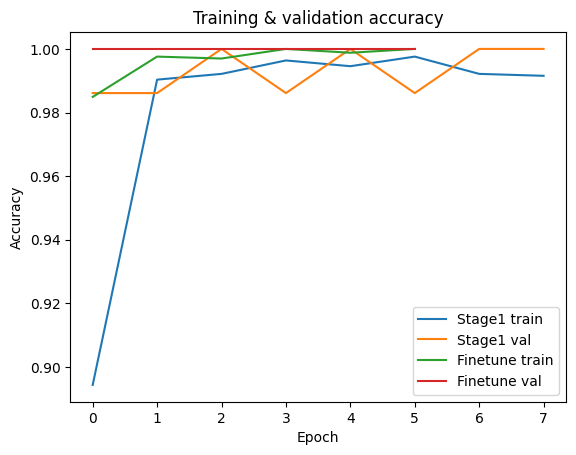

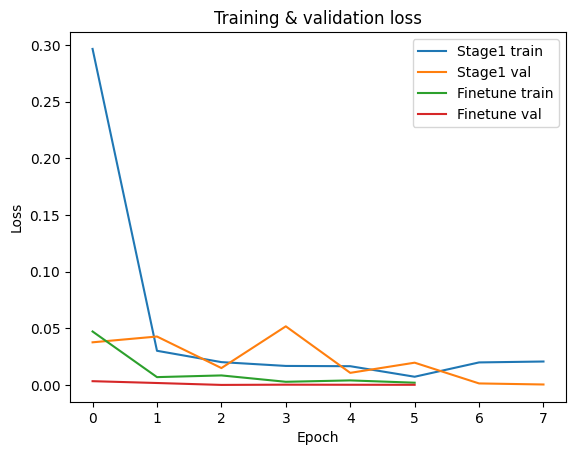

In [ ]:
def plot_history(histories, labels):
    plt.figure()
    for h, lab in zip(histories, labels):
        plt.plot(h.history['accuracy'], label=f'{lab} train')
        plt.plot(h.history['val_accuracy'], label=f'{lab} val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & validation accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    for h, lab in zip(histories, labels):
        plt.plot(h.history['loss'], label=f'{lab} train')
        plt.plot(h.history['val_loss'], label=f'{lab} val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & validation loss')
    plt.legend()
    plt.show()

plot_history([history1, history2], ["Stage1", "Finetune"])

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step

=== NEU validation classification report ===

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      1.00      1.00        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



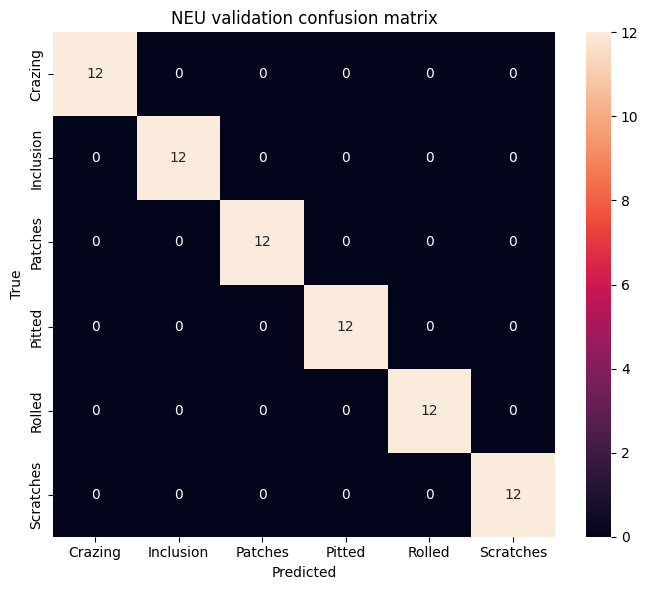

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step

=== NEU test classification report ===

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      1.00      1.00        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



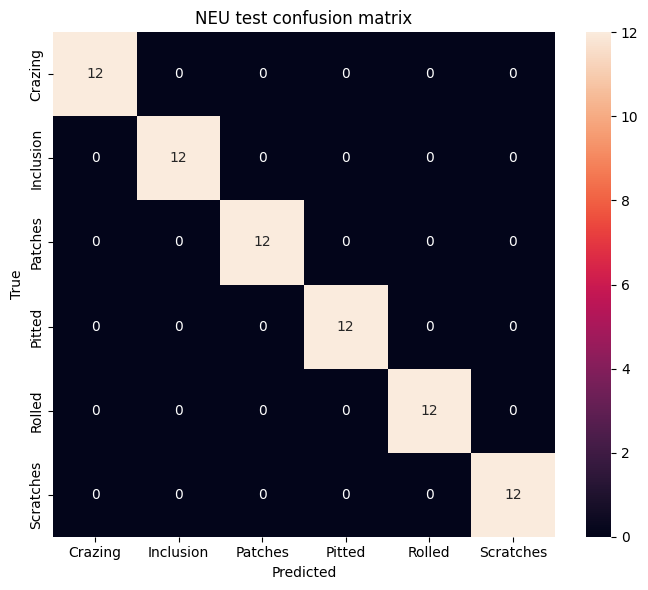

In [ ]:
def eval_on_generator(gen, dataset_name="dataset"):
    gen.reset()
    y_true = gen.classes
    y_prob = model.predict(gen)
    y_pred = np.argmax(y_prob, axis=1)

    labels = list(class_indices.keys())

    print(f"\n=== {dataset_name} classification report ===\n")
    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dataset_name} confusion matrix")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred

y_true_val, y_pred_val = eval_on_generator(val_gen, "NEU validation")
y_true_test, y_pred_test = eval_on_generator(test_gen, "NEU test")

In [ ]:
model.save("resnet50_neu_defect_classifier.h5")
print("Model saved as resnet50_neu_defect_classifier.h5")

Model saved as resnet50_neu_defect_classifier.h5


In [ ]:
# GC10 datagen with the SAME preprocessing as NEU
gc10_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

gc10_inclusion_gen = gc10_datagen.flow_from_directory(
    gc10_images_root,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=['inclusion'],   # only inclusion folder
    class_mode=None,         # no labels
    shuffle=False
)

print("GC10 inclusion images:", gc10_inclusion_gen.n)

Found 216 images belonging to 1 classes.
GC10 inclusion images: 216


In [ ]:
# Predict on GC10 inclusion images
gc10_inclusion_gen.reset()
gc10_probs = model.predict(gc10_inclusion_gen)
gc10_pred = np.argmax(gc10_probs, axis=1)

inv_class_indices = {v: k for k, v in class_indices.items()}
print("NEU classes:", inv_class_indices)

# find index of NEU "Inclusion" class
neu_inclusion_idx = [idx for idx, name in inv_class_indices.items()
                     if "inclu" in name.lower()][0]
print("NEU Inclusion index:", neu_inclusion_idx)

correct = np.sum(gc10_pred == neu_inclusion_idx)
total = len(gc10_pred)
print(f"\nGC10 'inclusion' predicted as NEU 'Inclusion': "
      f"{correct}/{total} ({correct/total:.3f})")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step
NEU classes: {0: 'Crazing', 1: 'Inclusion', 2: 'Patches', 3: 'Pitted', 4: 'Rolled', 5: 'Scratches'}
NEU Inclusion index: 1

GC10 'inclusion' predicted as NEU 'Inclusion': 85/216 (0.394)


Found 216 images belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


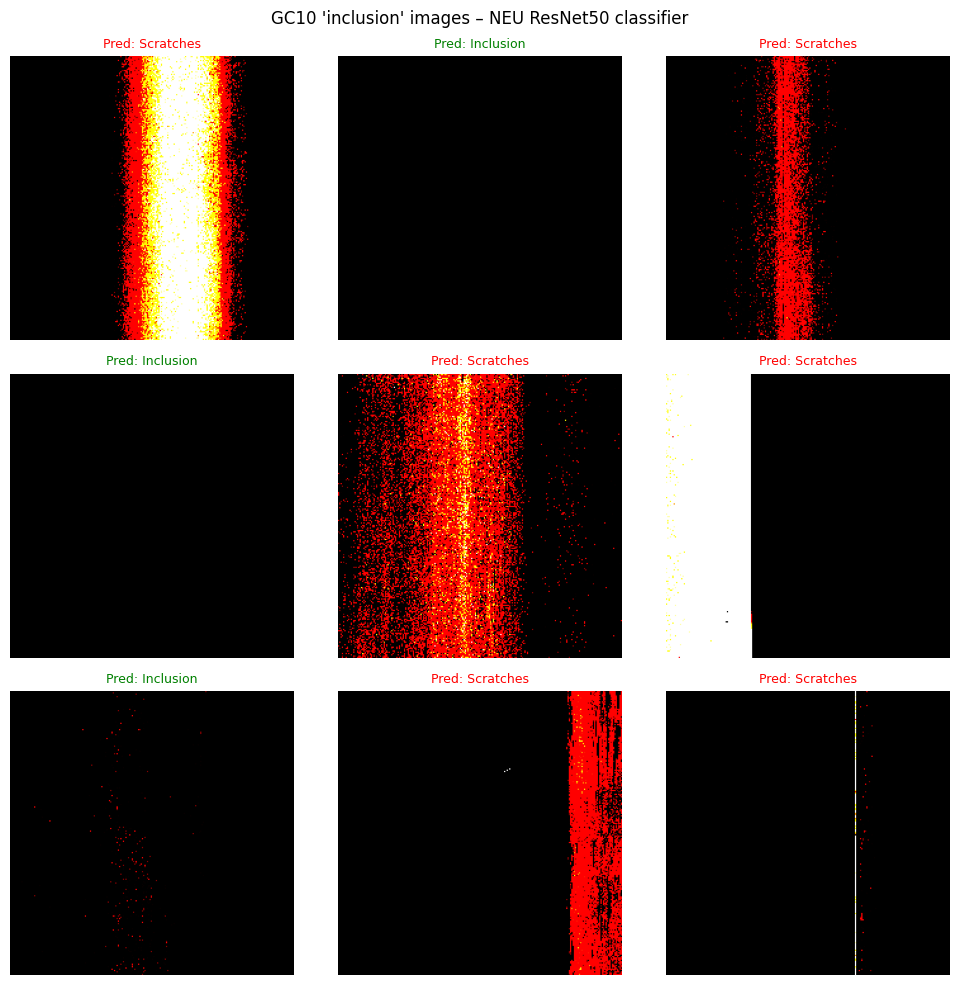

In [ ]:
# Use batch_size=1 for nice thumbnails
gc10_preview_gen = gc10_datagen.flow_from_directory(
    gc10_images_root,
    target_size=IMG_SIZE,
    batch_size=1,
    classes=['inclusion'],
    class_mode=None,
    shuffle=True
)

n_show = 9
plt.figure(figsize=(10,10))
for i in range(n_show):
    imgs = next(gc10_preview_gen)   # shape (1, H, W, 3)
    img = imgs[0]
    prob = model.predict(imgs)
    pred_idx = np.argmax(prob[0])
    pred_name = inv_class_indices[pred_idx]
    color = 'green' if pred_idx == neu_inclusion_idx else 'red'

    plt.subplot(3,3,i+1)
    plt.imshow((img + 1) / 2)  # roughly undo preprocess for nicer viewing
    plt.axis('off')
    plt.title(f"Pred: {pred_name}", color=color, fontsize=9)

plt.suptitle("GC10 'inclusion' images – NEU ResNet50 classifier", y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

val_gen.reset()
y_true_val = val_gen.classes
y_prob_val = model.predict(val_gen)
y_pred_val = y_prob_val.argmax(axis=1)
val_acc = accuracy_score(y_true_val, y_pred_val)

test_gen.reset()
y_true_test = test_gen.classes
y_prob_test = model.predict(test_gen)
y_pred_test = y_prob_test.argmax(axis=1)
test_acc = accuracy_score(y_true_test, y_pred_test)

print(f"NEU validation accuracy: {val_acc:.4f}")
print(f"NEU test accuracy      : {test_acc:.4f}")

# 2) GC10 inclusion accuracy (model trained only on NEU)
gc10_inclusion_gen.reset()
gc10_probs = model.predict(gc10_inclusion_gen)
gc10_pred = gc10_probs.argmax(axis=1)

inv_class_indices = {v:k for k, v in class_indices.items()}
neu_inclusion_idx = [i for i, name in inv_class_indices.items()
                     if "inclu" in name.lower()][0]

correct_gc10_inc = (gc10_pred == neu_inclusion_idx).sum()
total_gc10_inc = len(gc10_pred)
gc10_inc_acc = correct_gc10_inc / total_gc10_inc

print(f"GC10 'inclusion' images correctly predicted as NEU 'Inclusion': "
      f"{correct_gc10_inc}/{total_gc10_inc} ({gc10_inc_acc:.3f})")

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
NEU validation accuracy: 1.0000
NEU test accuracy      : 1.0000
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step
GC10 'inclusion' images correctly predicted as NEU 'Inclusion': 85/216 (0.394)
